# iOS device sensors

- *Accelerometer* - indicates the instantaneous acceleration of the device in three dimensional space

- *Gyroscope* - indicatates the instantaneous rotation around the device's three primary axes

- *Magnetometer* - indicates the device's orientation relative to Earth's magnetic field

## Data sample example

In [1]:
!head -5 data/sensors_data_2.txt

0,1559326636.829958,0.255325,-0.502029,-1.028046,0.443951,0.200743,0.415666,29.606125,-74.604645,18.656082
0,1559326636.839992,0.240738,-0.478897,-0.918045,0.325636,0.133373,0.397889,29.620789,-75.026749,18.934021
0,1559326636.850026,0.228043,-0.491455,-0.774460,0.213884,0.053723,0.346770,29.286835,-74.661758,18.959671
0,1559326636.860060,0.225693,-0.490204,-0.683121,0.115481,-0.005978,0.297200,29.212784,-75.049469,18.875061
0,1559326636.870094,0.215073,-0.467896,-0.619659,0.004867,-0.054696,0.251627,29.286987,-75.029800,19.014252


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd

# 50Hz
freq = 50
data_dir = 'data'

columns = ['mode', 'timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z']

datasets_trunc = []
data_files = !ls {data_dir}
for file_name in data_files:
    file_path = os.path.join(data_dir, file_name)
    data = pd.read_csv(file_path, sep=',', header=None, names=columns)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data.set_index('timestamp', inplace=True)
    data = data[30*freq: -30*freq] # trip 30 sec, both ends
    datasets_trunc.append(data)
    print('loaded: %s \tlen: %d' % (file_path, len(data)))

loaded: data/sensors_data_10.txt 	len: 33667
loaded: data/sensors_data_11.txt 	len: 34751
loaded: data/sensors_data_12.txt 	len: 28587
loaded: data/sensors_data_14.txt 	len: 29161
loaded: data/sensors_data_15.txt 	len: 120406
loaded: data/sensors_data_16.txt 	len: 46404
loaded: data/sensors_data_17.txt 	len: 36692
loaded: data/sensors_data_18.txt 	len: 404
loaded: data/sensors_data_2.txt 	len: 9181
loaded: data/sensors_data_20.txt 	len: 42670
loaded: data/sensors_data_3.txt 	len: 7316
loaded: data/sensors_data_4.txt 	len: 2972
loaded: data/sensors_data_5.txt 	len: 27768
loaded: data/sensors_data_6.txt 	len: 16155
loaded: data/sensors_data_7.txt 	len: 26962
loaded: data/sensors_data_8.txt 	len: 27688
loaded: data/sensors_data_9.txt 	len: 36273


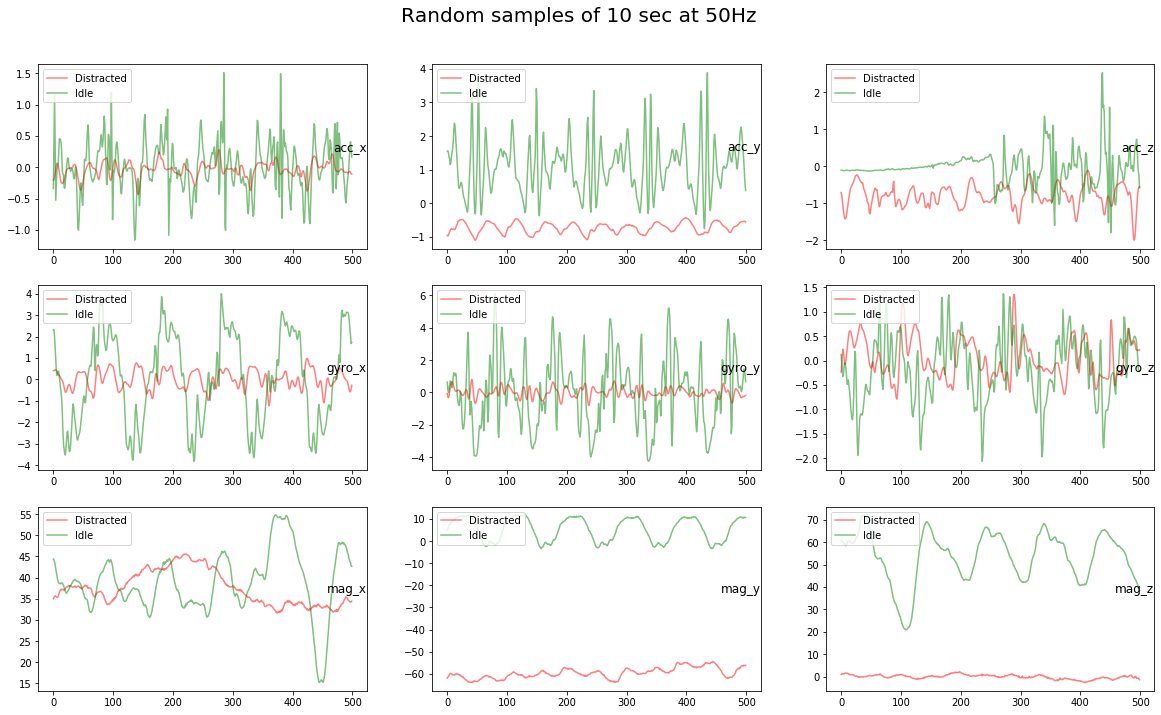

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

secs = 10 # plot 10 sec only

def plot_data(dfs):
    fdf = dfs[0]
    nrows = len(fdf.columns)
    cols = fdf.columns

    i = 1
    fig = plt.figure(figsize=(20, 40))
    title = "Random samples of %i sec at %iHz" % (secs, freq)
    fig.suptitle(title, fontsize=20, y=0.9)
    for row in range(1, nrows):
        plt.subplot(nrows, 3, i)
        for j in range(len(dfs)):
            values = dfs[j]
            begin = random.randint(0, len(values) - secs * freq)
            end = begin + secs * freq
            values = values.iloc[begin:end, :] 
            values = values.reset_index(drop=True)

            is_dist = values.iloc[0][0]
            label = "Distracted" if is_dist == 1 else "Idle"
            color = "red" if is_dist == 1 else "green"
            
            plt.plot(values.iloc[:, row], alpha=0.5, label=label, color=color)
            plt.legend(loc=2)
        plt.title(cols[row], y=0.5, loc='right')
        i += 1
    plt.show()

for i in range(1):
    plot_data([datasets_trunc[0], datasets_trunc[1]])

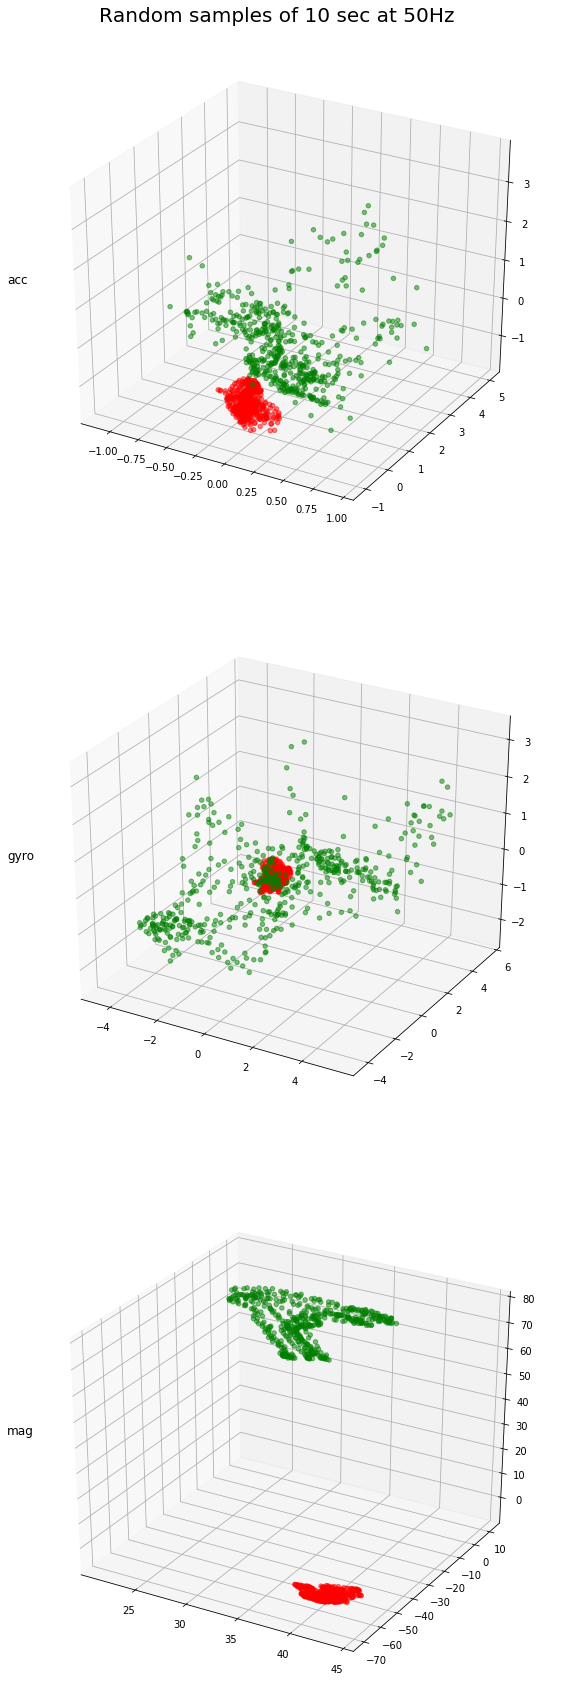

In [5]:
from mpl_toolkits.mplot3d import Axes3D

secs = 10 # plot 10 sec only

def plot_3d_data(dfs):
    sensors = ['acc', 'gyro', 'mag']
    nrows = len(sensors)    

    i = 1
    fig = plt.figure(figsize=(10, 30))
    title = "Random samples of %i sec at %iHz" % (secs, freq)
    fig.suptitle(title, fontsize=20, y=0.9)

    for row in range(nrows):
        ax = fig.add_subplot(nrows, 1, i, projection='3d')
        for j in range(len(dfs)):
            values = dfs[j]
            begin = random.randint(0, len(values) - secs * freq)
            end = begin + secs * freq
            values = values.iloc[begin:end, :] 
            values = values.reset_index(drop=True)

            is_dist = values.iloc[0][0]
            label = "Distracted" if is_dist == 1 else "Idle"
            color = "red" if is_dist == 1 else "green"
            
            sensor = sensors[row]
            x_line = values['%s_x' % (sensor)]
            y_line = values['%s_y' % (sensor)]
            z_line = values['%s_z' % (sensor)]    

            ax.scatter(x_line, y_line, z_line, alpha=0.5, color=color)
        plt.title(sensor, y=0.5, loc='left')
        i += 1
    plt.show()

for i in range(1):
    plot_3d_data([datasets_trunc[0], datasets_trunc[1]])

In [6]:
def unroll_df(df, wind_size=128):
    mode = df.iloc[0]['mode'].astype(int)
    data = df.drop('mode', axis=1)
    unrld_data = []
    proc_len = 0
    while (proc_len + wind_size) < len(data):
        data_batch = data[proc_len:proc_len+wind_size]
        data_batch.reset_index(drop=True)
        values = data_batch.unstack(level=1).values
        unrld_data.append(values)
        proc_len += wind_size

    proc_data = pd.DataFrame(unrld_data)
    proc_data['label'] = mode
    proc_data.head()
    return proc_data

In [7]:
unrolled_datasets = []
for dataset in datasets_trunc:
    unrolled_datasets.append(unroll_df(dataset, wind_size=50))
    
dataset = pd.concat(unrolled_datasets, axis=0)

In [8]:
dataset.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,label
67,-0.066849,-0.171188,-0.232330,-0.325119,-0.244766,-0.038315,0.072403,-0.120728,-0.032776,0.154739,...,44.352646,45.185242,45.649048,45.605621,45.374847,45.914963,45.832123,46.008972,47.175446,0
1862,-0.112228,-0.228134,-0.350327,-0.372711,-0.240936,-0.121368,-0.021088,0.062714,0.116821,0.112442,...,38.113266,38.679825,39.027451,40.410263,41.558029,42.655029,43.486862,44.411774,45.532410,0
1320,-0.447708,-0.611984,-0.653854,-0.827316,-1.027298,-0.715057,-0.090164,0.306335,0.047211,-0.631775,...,33.102875,33.594620,37.324280,38.050491,40.734451,41.167221,43.795929,42.914246,44.489563,0
383,-0.153503,-0.144043,-0.121735,-0.097427,-0.068726,-0.051834,-0.099564,-0.187653,-0.289825,-0.380142,...,0.772324,0.518845,0.813858,0.776016,1.399948,1.392807,1.655914,1.855606,2.109970,1
571,-1.767456,-1.721375,-1.601761,-1.626236,-1.691055,-1.507660,-1.281265,-1.294983,-1.367538,-1.447403,...,63.653320,62.873367,62.095734,62.384354,62.161346,61.977890,61.924652,62.106537,61.541611,0


## Preprocessing

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from utils import *

In [10]:
X = dataset.drop('label', axis=1).values
Y = dataset['label'].values

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)

## Model

Using TensorFlow 1.15.0 because CoreML converter doesn't currently have full support of TF 2.0 (RNN models)

In [12]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Activation, Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [13]:
def MyModel_LSTM():
    in_data = Input(shape=(50*9, ), dtype='float32')
    X = Reshape((50,9,), input_shape=(50*9,))(in_data)
    X = LSTM(50, return_sequences=True)(X)
    X = Dropout(0.5)(X)
    X = LSTM(50)(X)
    X = Dropout(0.5)(X)
    X = Dense(100, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=in_data, outputs=X)
    return model

# LSTM isnt supported on Android :(
def MyModel_FC():
    in_data = Input(shape=(50*9, ), dtype='float32')
    X = Dense(50, activation='relu')(in_data)
    X = Dropout(0.5)(X)
    X = Dense(50, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(20, activation='relu')(X)    
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=in_data, outputs=X)
    return model

In [14]:
model = MyModel_LSTM()
# model = MyModel_FC()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 9)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
____________________________________________

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
mc = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)

In [17]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, \
                    callbacks=[es, mc], validation_split=0.1)


Train on 8532 samples, validate on 949 samples
Epoch 1/100
8532/8532 [==============================] - 6s 690us/step - loss: 0.1251 - acc: 0.9528 - val_loss: 0.0178 - val_acc: 0.9916

Epoch 00001: val_acc improved from -inf to 0.99157, saving model to model.h5
Epoch 2/100
8532/8532 [==============================] - 5s 607us/step - loss: 0.0292 - acc: 0.9917 - val_loss: 0.0297 - val_acc: 0.9916

Epoch 00002: val_acc did not improve from 0.99157
Epoch 3/100
8532/8532 [==============================] - 6s 697us/step - loss: 0.0271 - acc: 0.9921 - val_loss: 0.0077 - val_acc: 0.9989

Epoch 00003: val_acc improved from 0.99157 to 0.99895, saving model to model.h5
Epoch 4/100
8532/8532 [==============================] - 6s 687us/step - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0134 - val_acc: 0.9958

Epoch 00004: val_acc did not improve from 0.99895
Epoch 5/100
8532/8532 [==============================] - 6s 645us/step - loss: 0.0095 - acc: 0.9973 - val_loss: 0.0028 - val_acc: 0.9989

Epoch

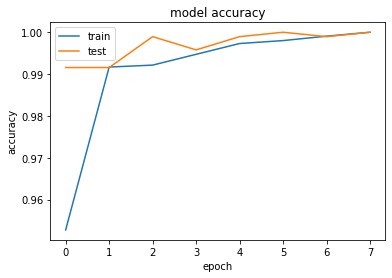

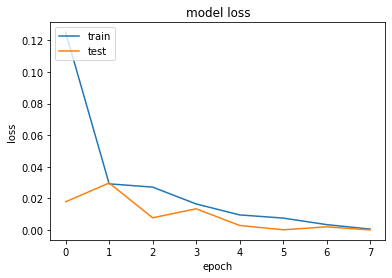

In [18]:
plot_model_accuracy(history)
plot_model_loss(history)

In [19]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test loss = ", loss)
print("Test accuracy = ", acc)

1054/1054 [==============================] - 0s 219us/step
Test loss =  1.4174613260930067e-05
Test accuracy =  1.0


In [ ]:
del model

model = load_model('model.h5')
model.summary()

In [ ]:
# brew install GraphViz
from keras.utils import plot_model
plot_model(model)

## CoreML converter

In [20]:
!./converter.py \
        --model model.h5 \
        --desc "Predicts either a phone is in the hands or in a pocket" \
        --input_desc "Sensor samples (acc, gyro, mag, 50Hz)" \
        --output_desc "1 - phone in the hands, 0 - phone in a pocket" \
        --author "Danylo Kostyshyn" \
        --license="MIT"

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2019-12-19 11:31:09.332214: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-12-19 11:31:09.347992: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc905bae5f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-19 11:31:09.348020: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 : input_1, <keras.engine.input_layer.InputLayer object at 0x13958f7d0>
1 : reshape_1, <keras.layers.core.Reshape object at 0x139582290>
2 : lstm_1, <k

## TensorFlow Lite model

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model_file('model.h5')
tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)